# Time series data science project

- **Chess players patterns discovery and analysis**
- **ariel-zil**

## Part 1 : EDA of game board

# 1. Problem decription

[chess](https://en.wikipedia.org/wiki/Chess), one of the most known games in the world is regularaly played by multiple people accross the world.

There are couple of known chess variants:
- **Blitz Chess and Bullet Chess**: These are faster versions of traditional chess. Blitz games typically allow 3 to 5 minutes for each player for all their moves, while bullet games might have even shorter times, such as 1 or 2 minutes.
- **Chess960 (Fischer Random Chess)**: Invented by former World Chess Champion Bobby Fischer, Chess960 starts with a random positioning of the non-pawn pieces on the first rank, with the placement of pieces mirrored on both sides. This variation has 960 possible starting positions, significantly reducing the reliance on opening preparation.
- **Xiangqi (Chinese Chess)**: While derived from the same Indian game as international chess, Xiangqi includes different pieces, a board with the "river" in the middle, and specific areas called "fortresses" for the generals (kings). It is massively popular in China and has different strategic principles.
- **Shogi (Japanese Chess)**: Shogi features a drop rule, allowing captured pieces to be returned to the board under the captor's control. This variant is characterized by its almost limitless possibilities for gameplay, as pieces can re-enter play rather than being permanently removed.

**Hopefully this work will try to uncover patterns on those games(depending on time constains)**

## 1.2 What does this work studies?
* This work tries to uncover various patterns in chess players skill over a period of time
* This work will focus on [ELO](https://en.wikipedia.org/wiki/Elo_rating_system) as a measure of the players skill

## 1.3 Datasets 

In this project we have tested  various chess datasets:

 1. [free indepeded chess server games from 2018 to 2020 blitz variant](https://www.kaggle.com/datasets/arielzilber/fics-2018-2020-blitz)

 2. [free indepeded chess server games from 2009 to 2023 standard variant](https://www.kaggle.com/datasets/arielzilber/fcis-standard-2009-to-2023)

**this notebook explores the first dataset**


 The datasetset contains many unneeded columns and so we will remove them and save the cleaned dataset
 

## 1.4 Questions to answer 


- What game strategy patterns are common in players
- How to diffrentiate betweeen a good player and a bad one

# 2. Imports

## 2.1 Import packages

In [28]:
from dotenv import find_dotenv, load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans
import time
from sklearn import metrics
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
import numpy as np
from warnings import filterwarnings
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from collections import Counter
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import rcParams

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['figure.figsize'] = 10,6
base_color = sb.color_palette()[0]




filterwarnings("ignore")

## 2.2 Load enviroment variables

In [29]:
PROJECT_PATH=os.getenv('PROJECT_PATH')
NUMBER_OF_GAMES_MINIMUM=int(os.getenv('NUMBER_OF_GAMES_MINIMUM'))
FICS_MIN_YEAR=int(os.getenv('FICS_MIN_YEAR'))
FICS_MAX_YEAR=int(os.getenv('FICS_MAX_YEAR'))

# 3. Basic data cleaning

In this section we will open the free independed chess server dataset which we will use.

This work has tested various datasets:

 1. [free indepeded chess server games from 2018 to 2020 blitz variant](https://www.kaggle.com/datasets/arielzilber/fics-2018-2020-blitz)

 2. [free indepeded chess server games from 2009 to 2023 standard variant](https://www.kaggle.com/datasets/arielzilber/fcis-standard-2009-to-2023)

**this notebook explores the second dataset**


 The datasetset contains many unneeded columns and so we will remove them and save the cleaned dataset

## 3.1 Load dataset

In [3]:
df=pd.read_csv(f"{PROJECT_PATH}/data/fics/proccessed/chess-games.csv")

: 

: 

In [113]:
for df in pd.read_csv(f"{PROJECT_PATH}/data/fics/proccessed/chess-games.csv",  chunksize=90000):
  sample=df
  break
sample["Year"]=sample.Date.apply(lambda r:r.split(".")[0])
sample=sample[sample.Year=="2018"]
sample["Timestap"]=sample["Date"]+" "+sample["Time"]
sample

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Event,Site,FICSGamesDBGameNo,White,Black,WhiteElo,BlackElo,...,WhiteClock,BlackClock,ECO,PlyCount,Result,Move,WhiteIsComp,BlackIsComp,Year,Timestap
9817,9817,9817,0,FICS rated blitz game,FICS freechess.org,455492835,rizaisfa,Eldongo,1540,1558,...,0:05:00.000,0:05:00.000,A00,23,1-0,| e3 e5 | d3 d5 | a3 c5 | b3 f5 | h3 Nc6 | g4 ...,NaN,NaN,2018,2018.08.31 07:58:00
10603,10603,602,0,FICS rated blitz game,FICS freechess.org,450877124,pietroa,weaker,828,973,...,0:02:00.000,0:02:00.000,B01,37,1/2-1/2,| e4 d5 | e5 d4 | d3 Nc6 | Nf3 Bg4 | h3 Bh5 | ...,NaN,NaN,2018,2018.08.19 13:51:00
17004,17004,7003,0,FICS rated blitz game,FICS freechess.org,450869119,Calx,DixierRebel,1621,1514,...,0:03:00.000,0:03:00.000,C42,35,0-1,| e4 e5 | Nf3 Nf6 | Nc3 Bb4 | d3 Bxc3+ | bxc3 ...,NaN,NaN,2018,2018.11.25 16:53:00
19391,19391,9390,0,FICS rated blitz game,FICS freechess.org,450866229,DixierRebel,henkdedenktenk,1504,1487,...,0:03:00.000,0:03:00.000,B03,99,1-0,| e4 Nf6 | e5 Nd5 | d4 Nc6 | c3 d6 | f4 g6 | N...,NaN,NaN,2018,2018.11.20 07:52:00
19408,19408,9407,0,FICS rated blitz game,FICS freechess.org,450866210,DixierRebel,WASFOX,1542,1542,...,0:03:00.000,0:03:00.000,A00,41,0-1,| e3 g6 | d4 c6 | c4 Bg7 | Nc3 e6 | Nf3 Ne7 | ...,NaN,NaN,2018,2018.11.10 15:59:00
20583,20583,581,0,FICS rated blitz game,FICS freechess.org,450976197,sirpicha,windbumwino,1563,1462,...,0:03:00.000,0:03:00.000,B06,127,1-0,| e4 g6 | f4 Bg7 | d4 d6 | Nf3 Nc6 | c3 e5 | f...,NaN,NaN,2018,2018.06.10 10:04:00
21723,21723,1721,0,FICS rated blitz game,FICS freechess.org,450974811,shatirhassan,criololoco,1461,1279,...,0:03:00.000,0:03:00.000,B21,121,1/2-1/2,| e4 c5 | d4 cxd4 | Qxd4 Nc6 | Qd1 e5 | Bc4 Nf...,NaN,NaN,2018,2018.06.01 08:23:00
22394,22394,2392,0,FICS rated blitz game,FICS freechess.org,450973983,turkeyboy,krell,1648,1598,...,0:03:00.000,0:03:00.000,B02,73,1-0,| e4 Nf6 | d3 d6 | h3 g6 | f4 Bg7 | c3 O-O | N...,NaN,NaN,2018,2018.09.22 05:14:00
22916,22916,2914,0,FICS rated blitz game,FICS freechess.org,450973335,thohai,kristianmach,1721,1740,...,0:03:00.000,0:03:00.000,A40,23,1-0,| d4 e6 | Nf3 b6 | e3 Bb7 | Bd3 c5 | O-O d5 | ...,NaN,NaN,2018,2018.07.02 12:09:00
28640,28640,8638,0,FICS rated blitz game,FICS freechess.org,450966058,maharais,ulfl,1392,1455,...,0:04:00.000,0:04:00.000,C01,119,1-0,| e4 e6 | d4 d5 | exd5 exd5 | Nc3 Nf6 | Bg5 Be...,NaN,NaN,2018,2018.10.31 15:05:00


In [ ]:
def extract_features(moves):
    pass

In [84]:
for moves in list(sample["Move"]):
    print(moves)

    break

| e3 e5 | d3 d5 | a3 c5 | b3 f5 | h3 Nc6 | g4 fxg4 | hxg4 Nf6 | Be2 Be7 | g5 Nd7 | Bh5+ g6 | Bxg6+ Kf8 | Qf3+ {Black resigns} 1-0


In [89]:
m_as_list=[[x for x in m.split(" ") if len(x)>0] for m in moves.split("|")][1:]
end_status=[]

[['e3', 'e5'],
 ['d3', 'd5'],
 ['a3', 'c5'],
 ['b3', 'f5'],
 ['h3', 'Nc6'],
 ['g4', 'fxg4'],
 ['hxg4', 'Nf6'],
 ['Be2', 'Be7'],
 ['g5', 'Nd7'],
 ['Bh5+', 'g6'],
 ['Bxg6+', 'Kf8'],
 ['Qf3+', '{Black', 'resigns}', '1-0']]

In [98]:
def get_moves(sample):
    moves=list(sample["Move"])[0].split("|")
    result=[]

    for m in moves:
        if len(m)==0:
            continue
        if "{" in m:
            m=m[:m.index("{")]
        
        for move_code in [x for x in m.split(" ") if len(x)>0]:
            result.append(move_code)

    return result


moves=get_moves(sample)

In [53]:
import chess
import chess.engine

# Specify the path to the Stockfish binary
STOCKFISH_PATH = '/usr/games/stockfish'

# Initialize the Stockfish engine
engine = chess.engine.SimpleEngine.popen_uci(STOCKFISH_PATH)


In [106]:
engine.

TypeError: 'SimpleEngine' object is not iterable

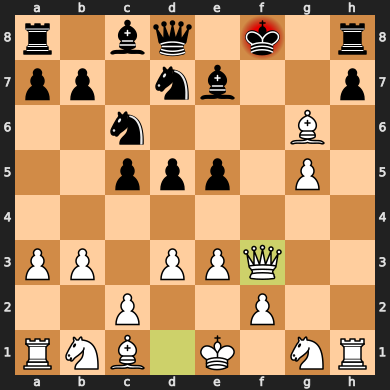

In [107]:
board

In [111]:
def extract_moves_features(moves):
    board = chess.Board()
    total_errors=[]
    # Apply moves to the board
    for move in moves:
        board.push_san(move)

        # Analyze the position
        info = engine.analyse(board, chess.engine.Limit(time=0.1))
        score = info["score"].white().score(mate_score=100000)
        print(f"Current board evaluation: {score}")

        # Get the best move recommendation
        result = engine.play(board, chess.engine.Limit(time=0.1))
        print(f"Recommended move: {result.move}")
        print(f"Is the last move an error? {'Yes' if board.peek() != result.move else 'No'}")

extract_moves_features(moves)

Current board evaluation: 11
Recommended move: e7e6
Is the last move an error? Yes
Current board evaluation: 28
Recommended move: d2d4
Is the last move an error? Yes
Current board evaluation: -47
Recommended move: d7d5
Is the last move an error? Yes
Current board evaluation: -50
Recommended move: g1f3
Is the last move an error? Yes
Current board evaluation: -69
Recommended move: f8d6
Is the last move an error? Yes
Current board evaluation: -44
Recommended move: d3d4
Is the last move an error? Yes
Current board evaluation: -86
Recommended move: b8c6
Is the last move an error? Yes
Current board evaluation: -44
Recommended move: d3d4
Is the last move an error? Yes
Current board evaluation: -148
Recommended move: g8f6
Is the last move an error? Yes
Current board evaluation: -150
Recommended move: g2g3
Is the last move an error? Yes
Current board evaluation: -156
Recommended move: g7g6
Is the last move an error? Yes
Current board evaluation: -127
Recommended move: h3g4
Is the last move an e

In [108]:
board = chess.Board()
for move in moves:
    info_before = engine.analyse(board, chess.engine.Limit(time=0.1))
    print(info_before)
    score_before = info_before['score'].relative.score(mate_score=10000)

    board.push_san(move)
    info_after = engine.analyse(board, chess.engine.Limit(time=0.1))
    score_after = info_after['score'].relative.score(mate_score=10000)
    print(score_after-score_before)


{'string': 'NNUE evaluation using nn-13406b1dcbe0.nnue enabled', 'depth': 15, 'seldepth': 21, 'multipv': 1, 'score': PovScore(Cp(+47), WHITE), 'nodes': 93190, 'nps': 922673, 'tbhits': 0, 'time': 0.101, 'pv': [Move.from_uci('e2e4'), Move.from_uci('c7c5')], 'upperbound': True}
-64
{'string': 'NNUE evaluation using nn-13406b1dcbe0.nnue enabled', 'depth': 14, 'seldepth': 14, 'multipv': 1, 'score': PovScore(Cp(-24), BLACK), 'nodes': 103631, 'nps': 1026049, 'tbhits': 0, 'time': 0.101, 'pv': [Move.from_uci('d7d5'), Move.from_uci('c2c4'), Move.from_uci('e7e6'), Move.from_uci('g1f3'), Move.from_uci('g8f6'), Move.from_uci('d2d4'), Move.from_uci('b7b6'), Move.from_uci('c4d5'), Move.from_uci('e6d5'), Move.from_uci('f1d3'), Move.from_uci('f8d6'), Move.from_uci('e1g1'), Move.from_uci('c8b7')]}
53
{'string': 'NNUE evaluation using nn-13406b1dcbe0.nnue enabled', 'depth': 18, 'seldepth': 25, 'multipv': 1, 'score': PovScore(Cp(+24), WHITE), 'nodes': 106608, 'nps': 1055524, 'tbhits': 0, 'time': 0.101, 'p

In [68]:
move

Move.from_uci('a8a1')

In [77]:
board.push_san(m)


Move.from_uci('e2e3')

In [79]:
info_after = engine.analyse(board, chess.engine.Limit(time=0.1))

score_before = info_before['score'].relative.score(mate_score=10000)
score_after = info_after['score'].relative.score(mate_score=10000)

In [81]:
score_before

34

In [80]:
score_after

-16

In [41]:
from stockfish import Stockfish

stockfish = Stockfish()

In [ ]:
#https://github.com/johndoknjas/stockfish-1

In [ ]:
def evaluate_mistakes(game):
    board = chess.Board()
    for move in game.mainline_moves():
        info_before = engine.analyse(board, chess.engine.Limit(time=0.1))
        board.push(move)
        info_after = engine.analyse(board, chess.engine.Limit(time=0.1))
        
        score_before = info_before['score'].relative.score(mate_score=10000)
        score_after = info_after['score'].relative.score(mate_score=10000)
        
        if score_before - score_after > 100:  # Example threshold
            print(f"Mistake found on move {board.fullmove_number}: {move} caused a significant drop in evaluation.")
            print(f"Evaluation went from {score_before} to {score_after}")

# Run the analysis
evaluate_mistakes(game)

## 3.2 Remove columns

In [6]:
for c in [c for c in list(df.columns) if "Unnamed" in c]:
    df=df.drop(columns=c)
    
df["Year"]=df["Date"].apply(lambda r:r.split(".")[0])
df=df.drop(columns="Site")
df=df.drop(columns="WhiteIsComp")
df=df.drop(columns="BlackIsComp")
df.to_csv(f"{PROJECT_PATH}/data/fics/interim/chess-games-clean.csv")

# 4. Basic data exploration
